In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram
from neuropy.io.usvio import detect_tone

from tracefc.io.session_directory import get_session_dir
import tracefc.io.traceio as traceio

In [2]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Finn2', 'recall1'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data3/Trace_FC/Recording_Rats/Finn2/2023_05_09_recall1/Finn2_recall1_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 3598.94 seconds 
duration: 1.00 hours 



### Read in miniscope data

In [5]:
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Time since rec start (sec)"] = (sync_df['Datetime'] - sync_df.loc[0, 'Datetime']).dt.total_seconds()
sync_df

start time = 2023-05-09 12:14:33-04:00
start time = 2023-05-09 12:35:50-04:00
start time = 2023-05-09 12:57:20-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time,Time since rec start (sec)
0,0,2023-05-09 12:14:33-04:00,start,0,0.000000,0,0.0000,0.000000
1,0,2023-05-09 12:35:26.794100-04:00,stop,37613823,1253.794100,1567242,1253.7936,1253.794100
2,1,2023-05-09 12:35:50-04:00,start,37613824,1253.794133,1567243,1253.7944,1277.000000
3,1,2023-05-09 12:57:05.383433333-04:00,stop,75875327,2529.177567,3161471,2529.1768,2552.383433
4,2,2023-05-09 12:57:20-04:00,start,75875328,2529.177600,3161472,2529.1776,2567.000000
5,2,2023-05-09 13:15:09.764233333-04:00,stop,107968255,3598.941833,4498677,3598.9416,3636.764233


In [6]:
import neuropy.io.miniscopeio as miniio
mini = miniio.MiniscopeIO(sess.basepath)

In [7]:
mini.load_all_orientation()
mini.load_all_timestamps()

including folder /data3/Trace_FC/Recording_Rats/Finn2/2023_05_09_recall1/1_tone_recall/tone_recall/Finn2/gobears/2023_05_09/12_16_49
including folder /data3/Trace_FC/Recording_Rats/Finn2/2023_05_09_recall1/2_control_tone_recall/control_tone_recall/Finn2/gobears/2023_05_09/12_37_22
including folder /data3/Trace_FC/Recording_Rats/Finn2/2023_05_09_recall1/3_ctx_recall/ctx_recall/Finn2/gobears/2023_05_09/12_58_58


,Frame Number,Time Stamp (ms),Buffer Index,Timestamps
0,0,-9,0,2023-05-09 12:16:49.245
1,1,82,0,2023-05-09 12:16:49.336
2,2,125,0,2023-05-09 12:16:49.379
3,3,191,0,2023-05-09 12:16:49.445
4,4,260,0,2023-05-09 12:16:49.514
...,...,...,...,...
14251,14251,960198,0,2023-05-09 13:14:58.709
14252,14252,960266,0,2023-05-09 13:14:58.777
14253,14253,960332,0,2023-05-09 13:14:58.843
14254,14254,960399,0,2023-05-09 13:14:58.910


In [8]:
mini.orient_all

,Time Stamp (ms),qw,qx,qy,qz,Timestamps,roll,pitch,yaw
0,-9,0.469910,-0.245239,-0.002747,0.847961,2023-05-09 12:16:49.245,-0.261188,0.426101,2.072713
1,82,0.403442,-0.284363,0.020691,0.869446,2023-05-09 12:16:49.336,-0.227046,0.536555,2.210016
2,125,0.387085,-0.271667,0.051147,0.879639,2023-05-09 12:16:49.379,-0.141100,0.543950,2.273097
3,191,0.351563,-0.270813,0.058105,0.894287,2023-05-09 12:16:49.445,-0.101812,0.552918,2.363599
4,260,0.339600,-0.288391,0.013733,0.895142,2023-05-09 12:16:49.514,-0.202735,0.553489,2.358594
...,...,...,...,...,...,...,...,...,...
14251,960198,0.614197,-0.146667,-0.097717,0.769226,2023-05-09 13:14:58.709,-0.338801,0.105801,1.775882
14252,960266,0.615967,-0.147888,-0.096985,0.767639,2023-05-09 13:14:58.777,-0.339505,0.107784,1.770640
14253,960332,0.616760,-0.147705,-0.098022,0.766907,2023-05-09 13:14:58.843,-0.340987,0.105841,1.768707
14254,960399,0.616028,-0.147217,-0.098694,0.767517,2023-05-09 13:14:58.910,-0.341294,0.104579,1.770864


In [9]:
sync_df

,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time,Time since rec start (sec)
0,0,2023-05-09 12:14:33-04:00,start,0,0.000000,0,0.0000,0.000000
1,0,2023-05-09 12:35:26.794100-04:00,stop,37613823,1253.794100,1567242,1253.7936,1253.794100
2,1,2023-05-09 12:35:50-04:00,start,37613824,1253.794133,1567243,1253.7944,1277.000000
3,1,2023-05-09 12:57:05.383433333-04:00,stop,75875327,2529.177567,3161471,2529.1768,2552.383433
4,2,2023-05-09 12:57:20-04:00,start,75875328,2529.177600,3161472,2529.1776,2567.000000
5,2,2023-05-09 13:15:09.764233333-04:00,stop,107968255,3598.941833,4498677,3598.9416,3636.764233


In [10]:
rough_headsensor_times = (mini.orient_all["Timestamps"].dt.tz_localize(tz="America/Detroit") - sync_df.loc[0, "Datetime"]).dt.total_seconds()
mini.orient_all["Rough eeg time (s)"] = rough_headsensor_times
mini.orient_all

,Time Stamp (ms),qw,qx,qy,qz,Timestamps,roll,pitch,yaw,Rough eeg time (s)
0,-9,0.469910,-0.245239,-0.002747,0.847961,2023-05-09 12:16:49.245,-0.261188,0.426101,2.072713,136.245
1,82,0.403442,-0.284363,0.020691,0.869446,2023-05-09 12:16:49.336,-0.227046,0.536555,2.210016,136.336
2,125,0.387085,-0.271667,0.051147,0.879639,2023-05-09 12:16:49.379,-0.141100,0.543950,2.273097,136.379
3,191,0.351563,-0.270813,0.058105,0.894287,2023-05-09 12:16:49.445,-0.101812,0.552918,2.363599,136.445
4,260,0.339600,-0.288391,0.013733,0.895142,2023-05-09 12:16:49.514,-0.202735,0.553489,2.358594,136.514
...,...,...,...,...,...,...,...,...,...,...
14251,960198,0.614197,-0.146667,-0.097717,0.769226,2023-05-09 13:14:58.709,-0.338801,0.105801,1.775882,3625.709
14252,960266,0.615967,-0.147888,-0.096985,0.767639,2023-05-09 13:14:58.777,-0.339505,0.107784,1.770640,3625.777
14253,960332,0.616760,-0.147705,-0.098022,0.766907,2023-05-09 13:14:58.843,-0.340987,0.105841,1.768707,3625.843
14254,960399,0.616028,-0.147217,-0.098694,0.767517,2023-05-09 13:14:58.910,-0.341294,0.104579,1.770864,3625.910


In [11]:
rough_headsensor_times = (mini.orient_all["Timestamps"].dt.tz_localize(tz="America/Detroit") - sync_df.loc[0, "Datetime"]).dt.total_seconds()
mini.orient_all["Time from OE start"] = rough_headsensor_times
mini.orient_all

# Key line of code - converts miniscope time (which doesn't account for disconnects) to eeg time (which cuts out disconnect times)
mini.orient_all["Rough eeg time (s)"] = np.interp(mini.orient_all["Time from OE start"], sync_df["Time since rec start (sec)"], 
                                            sync_df["eeg_time"])
mini.orient_all

,Time Stamp (ms),qw,qx,qy,qz,Timestamps,roll,pitch,yaw,Rough eeg time (s),Time from OE start
0,-9,0.469910,-0.245239,-0.002747,0.847961,2023-05-09 12:16:49.245,-0.261188,0.426101,2.072713,136.244946,136.245
1,82,0.403442,-0.284363,0.020691,0.869446,2023-05-09 12:16:49.336,-0.227046,0.536555,2.210016,136.335946,136.336
2,125,0.387085,-0.271667,0.051147,0.879639,2023-05-09 12:16:49.379,-0.141100,0.543950,2.273097,136.378946,136.379
3,191,0.351563,-0.270813,0.058105,0.894287,2023-05-09 12:16:49.445,-0.101812,0.552918,2.363599,136.444946,136.445
4,260,0.339600,-0.288391,0.013733,0.895142,2023-05-09 12:16:49.514,-0.202735,0.553489,2.358594,136.513946,136.514
...,...,...,...,...,...,...,...,...,...,...,...
14251,960198,0.614197,-0.146667,-0.097717,0.769226,2023-05-09 13:14:58.709,-0.338801,0.105801,1.775882,3587.886369,3625.709
14252,960266,0.615967,-0.147888,-0.096985,0.767639,2023-05-09 13:14:58.777,-0.339505,0.107784,1.770640,3587.954369,3625.777
14253,960332,0.616760,-0.147705,-0.098022,0.766907,2023-05-09 13:14:58.843,-0.340987,0.105841,1.768707,3588.020369,3625.843
14254,960399,0.616028,-0.147217,-0.098694,0.767517,2023-05-09 13:14:58.910,-0.341294,0.104579,1.770864,3588.087369,3625.910


In [12]:
cs_epochs_file = sess.filePrefix.with_suffix(".cs_epochs.npy")
sess.cs_epochs = Epoch(epochs=None, file=cs_epochs_file)
sess.cs_epochs.starts

array([ 197.3418  ,  261.043966,  328.820033,  392.536766,  466.370566,
        530.087266,  599.893266,  661.550166,  738.459333,  811.309833,
        877.041166,  941.7738  , 1014.6238  , 1082.369866, 1148.116966])

In [13]:
csn_epochs_file = sess.filePrefix.with_suffix(".csn_epochs.npy")
sess.csn_epochs = Epoch(epochs=None, file=csn_epochs_file)
sess.csn_epochs.starts

array([1407.355833, 1477.146333, 1544.922633, 1608.6405  , 1678.430633,
       1757.369466, 1829.205633, 1909.128533, 1981.979466, 2053.8147  ,
       2132.7228  , 2200.4982  ])

In [14]:
cs2_epochs_file = sess.filePrefix.with_suffix(".cs2_epochs.npy")
sess.cs2_epochs = Epoch(epochs=None, file=cs2_epochs_file)
sess.cs2_epochs.starts

array([2264.215533, 2326.901433, 2394.677866])

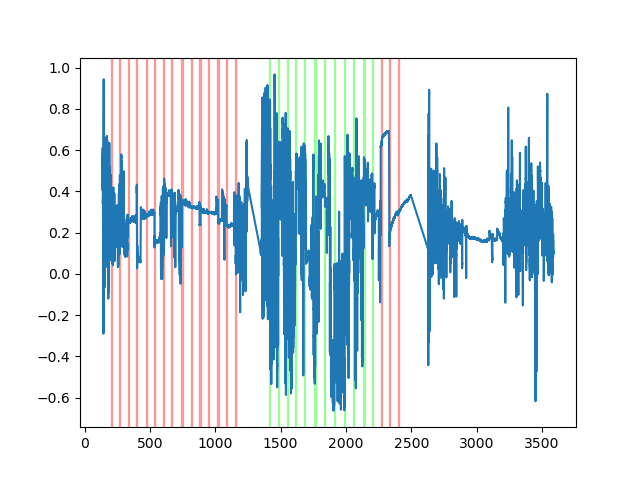

In [15]:
%matplotlib widget
_, ax = plt.subplots()
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.pitch)
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

In [16]:
def calc_head_speed(df):

    angle_diffs = []
    for ang_axis in ["roll", "pitch", "yaw"]:
        axis_diff = df[ang_axis].diff()

        # Correct any swings of > 2*pi
        axis_diff[axis_diff > 1.8 * np.pi] = axis_diff[axis_diff > 1.8 * np.pi] - 2 * np.pi
        axis_diff[axis_diff < -1.8 * np.pi] = axis_diff[axis_diff < -1.8 * np.pi] + 2 * np.pi
        angle_diffs.append(axis_diff.values)
    # head_speed = np.sqrt(np.square(df.roll.diff()) + np.square(df.pitch.diff()) + np.square(df.yaw.diff())) / df["Rough eeg time (s)"].diff()
    head_speed = np.sqrt(np.square(angle_diffs[0]) + np.square(angle_diffs[1]) + np.square(angle_diffs[2]))
    return head_speed
calc_head_speed(mini.orient_all)

array([       nan, 0.1794932 , 0.10686801, ..., 0.00311522, 0.00251802,
       0.00403402])

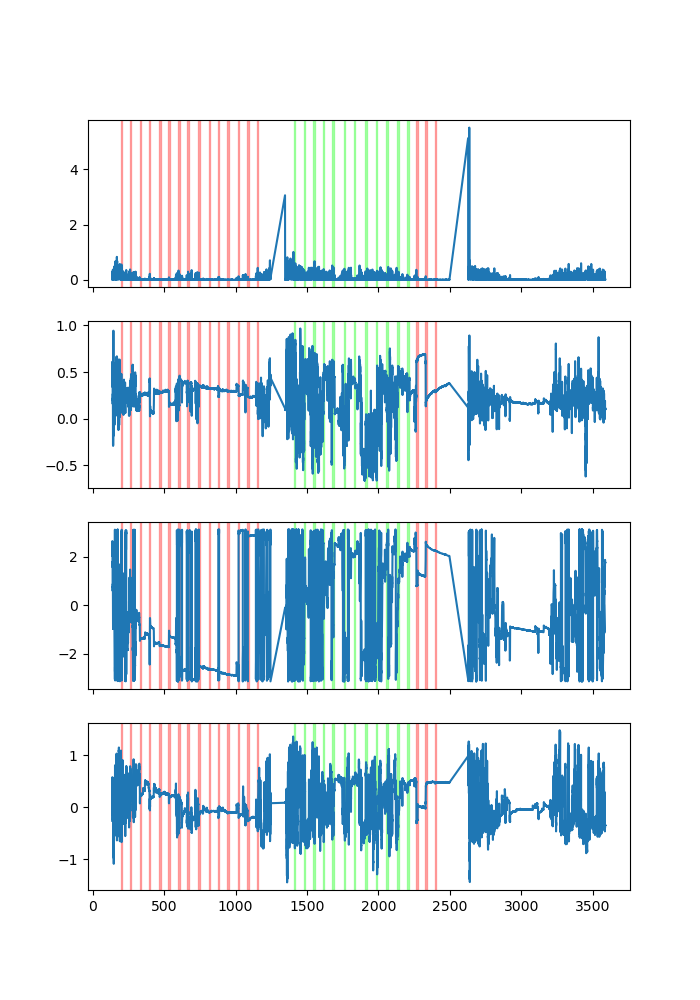

In [17]:
%matplotlib widget
_, axs = plt.subplots(4, 1, figsize=(7, 10), sharex=True)
ax = axs[0]
mini.orient_all["Head speed"] = calc_head_speed(mini.orient_all)
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all["Head speed"])
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

ax = axs[1]
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.pitch)
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

ax = axs[2]
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.yaw)
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

ax = axs[3]
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.roll)
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

/data3/Trace_FC/Recording_Rats/Finn2/2023_05_09_recall1/Finn2_recall1_denoised.probegroup.npy saved


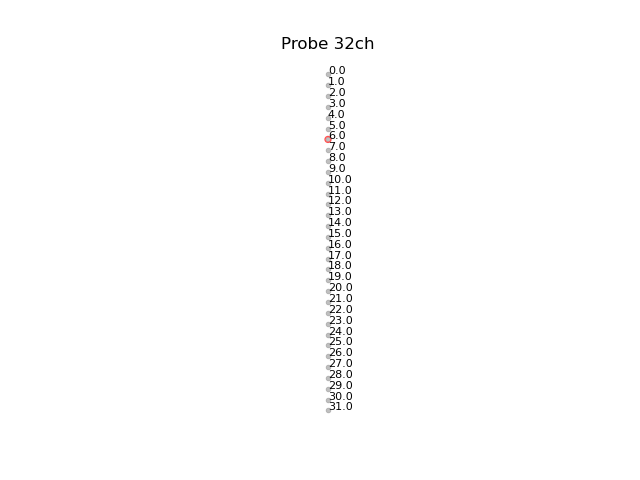

In [18]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

In [19]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()


from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 7

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Existing artifact epochs file loaded
Total artifact time = 9.6 seconds
Best channel for theta: [7]
233 epochs remaining with durations within (1,20)


In [20]:

# Run wavelet on theta range
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=theta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

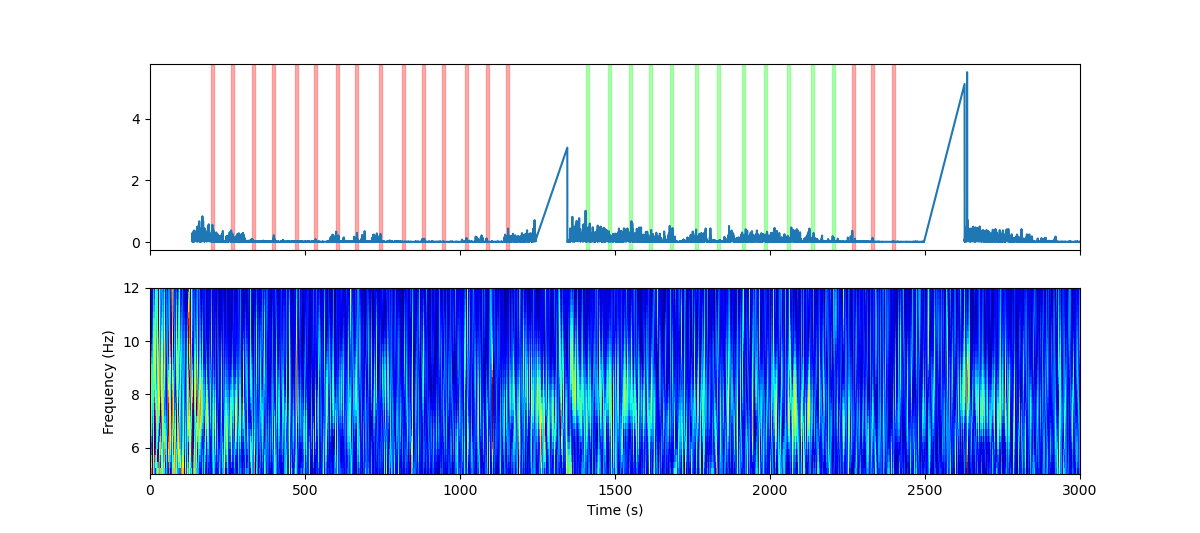

In [21]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(2, 1, figsize=(12,5.333), sharex=True)
time_to_plot = [0, 3000]
theta_freq_lims = [5, 12]

ax1 = axs[0]
mini.orient_all["Head speed"] = calc_head_speed(mini.orient_all)
ax1.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all["Head speed"])
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax1.axvspan(start, stop, color=[1, 0, 0, 0.3])
for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax1.axvspan(start, stop, color=[0, 1, 0, 0.3])
for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax1.axvspan(start, stop, color=[1, 0, 0, 0.3])


ax2 = axs[1]
plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax2)

plt.show()


In [22]:
start_buffer, stop_buffer = 10, 50
start = sess.cs_epochs.starts[0]
stop = sess.cs_epochs.stops[0]
eeg_times = mini.orient_all["Rough eeg time (s)"]
trial_bool = (eeg_times > (start - start_buffer)) & (eeg_times < (stop + stop_buffer))
mini.orient_all.loc[trial_bool, "Head speed"]

759     0.080994
760     0.089447
761     0.335931
762     0.040782
763     0.147153
          ...   
1792    0.100925
1793    0.064599
1794    0.073056
1795    0.041324
1796    0.095441
Name: Head speed, Length: 1038, dtype: float64

/tmp/ipykernel_2422293/4111180037.py:30: RuntimeWarning: Mean of empty slice
  average_speed = np.nanmean(all_speeds, axis=0)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

/tmp/ipykernel_2422293/4111180037.py:60: RuntimeWarning: Mean of empty slice
  average_speed = np.nanmean(all_speeds, axis=0)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

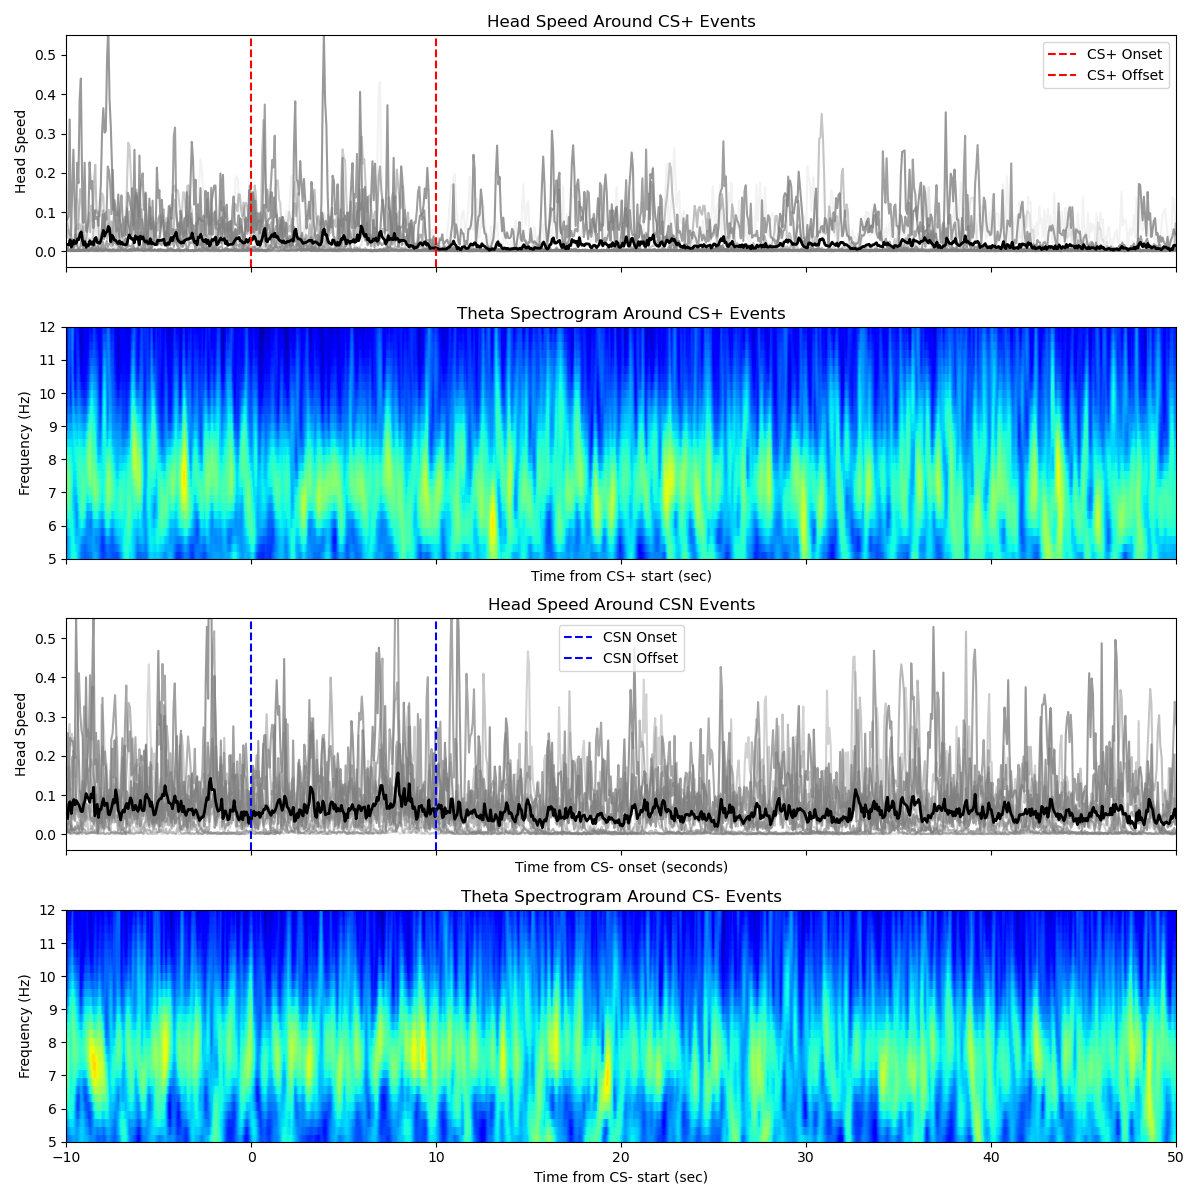

In [23]:
import matplotlib.pyplot as plt
import numpy as np

sampling_rate = 30
theta_freq_lims = [5, 12]  
usv_buffer_sec = (10, 50)  

fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Head Speed for CS+ in the first subplot
ax1 = axs[0]
epochs_use = sess.cs_epochs
eeg_times = mini.orient_all["Rough eeg time (s)"]
mini_sr = 15  # fps
start_buffer = 10
stop_buffer = 50

tinterp = np.arange(-start_buffer, (10 + stop_buffer) + 1/mini_sr, 1/mini_sr)
all_speeds = np.ones((epochs_use.n_epochs, len(tinterp)))*np.nan

for idt, (start, stop) in enumerate(zip(epochs_use.starts, epochs_use.stops)):
    trial_bool = (eeg_times > (start - start_buffer)) & (eeg_times < (stop + stop_buffer))
    speeds = mini.orient_all.loc[trial_bool, "Head speed"].values
    times = mini.orient_all.loc[trial_bool, "Rough eeg time (s)"].values - start

    ax1.plot(times, speeds, color='grey', alpha=0.8 - idt*0.05)
    data_bin_id = np.digitize(times, tinterp)
    all_speeds[idt, data_bin_id] = speeds

average_speed = np.nanmean(all_speeds, axis=0)
ax1.plot(tinterp, average_speed, color='black', linewidth=2)
ax1.axvline(x=0, color='red', linestyle='--', label='CS+ Onset')
ax1.axvline(x=10, color='red', linestyle='--', label='CS+ Offset')
ax1.set_ylabel('Head Speed')
ax1.set_title('Head Speed Around CS+ Events')
ax1.legend()
ax1.set_ylim(bottom=-0.04, top=0.55)

# Theta Power Spectrogram in the second subplot
ax3 = axs[1]
wv_theta_mean_cs = wv_theta.get_pe_mean_spec(sess.cs_epochs.starts, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs, print_ignored_frames=False)
plot_spectrogram(wv_theta_mean_cs, np.multiply(usv_buffer_sec, (-1, 1)), theta_freq_lims, ax3)
ax3.set_xlabel('Time from CS+ start (sec)')
ax3.set_title('Theta Spectrogram Around CS+ Events')

# Head Speed for CS- in the third subplot
ax2 = axs[2]
epochs_use = sess.csn_epochs
all_speeds = np.ones((epochs_use.n_epochs, len(tinterp)))*np.nan

for idt, (start, stop) in enumerate(zip(epochs_use.starts, epochs_use.stops)):
    trial_bool = (eeg_times > (start - start_buffer)) & (eeg_times < (stop + stop_buffer))
    speeds = mini.orient_all.loc[trial_bool, "Head speed"].values
    times = mini.orient_all.loc[trial_bool, "Rough eeg time (s)"].values - start

    ax2.plot(times, speeds, color='grey', alpha=0.8 - idt*0.05)
    data_bin_id = np.digitize(times, tinterp)
    all_speeds[idt, data_bin_id] = speeds

average_speed = np.nanmean(all_speeds, axis=0)
ax2.plot(tinterp, average_speed, color='black', linewidth=2)
ax2.axvline(x=0, color='blue', linestyle='--', label='CSN Onset')
ax2.axvline(x=10, color='blue', linestyle='--', label='CSN Offset')
ax2.set_xlabel('Time from CS- onset (seconds)')
ax2.set_ylabel('Head Speed')
ax2.set_title('Head Speed Around CSN Events')
ax2.legend()
ax2.set_ylim(bottom=-0.04, top=0.55)

# Theta Power Spectrogram for CS- in the fourth subplot
ax4 = axs[3]
wv_theta_mean_csn = wv_theta.get_pe_mean_spec(sess.csn_epochs.starts, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs, print_ignored_frames=False)
plot_spectrogram(wv_theta_mean_csn, np.multiply(usv_buffer_sec, (-1, 1)), theta_freq_lims, ax4)
ax4.set_xlabel('Time from CS- start (sec)')
ax4.set_title('Theta Spectrogram Around CS- Events')

plt.tight_layout()
plt.show()

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from CS+ start (sec)')

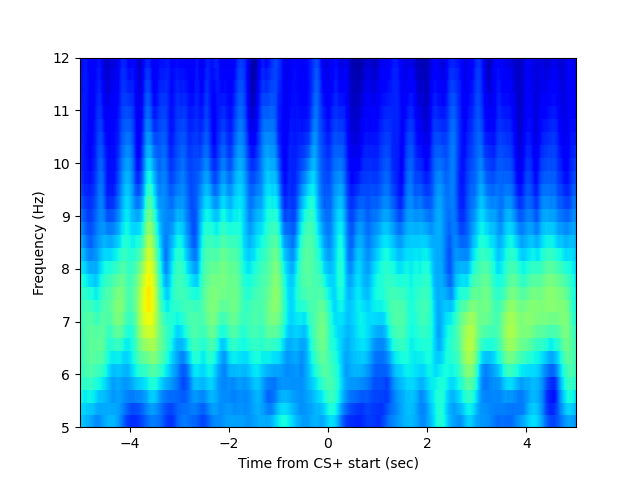

In [24]:
# Example code to plot theta at CS+ starts
usv_buffer_sec = (5,5)
wv_theta_mean = wv_theta.get_pe_mean_spec(sess.cs_epochs.starts, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from CS+ start (sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from CS+ stop (sec)')

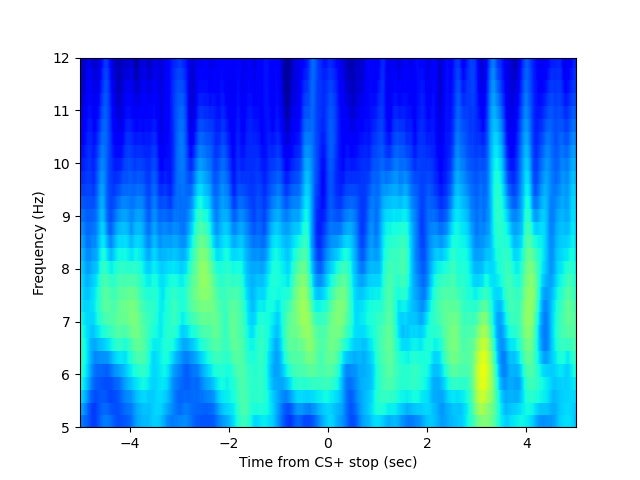

In [25]:
# Example code to plot theta at CS+ stops
usv_buffer_sec = (5,5)
wv_theta_mean = wv_theta.get_pe_mean_spec(sess.cs_epochs.stops, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from CS+ stop (sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from CS- start (sec)')

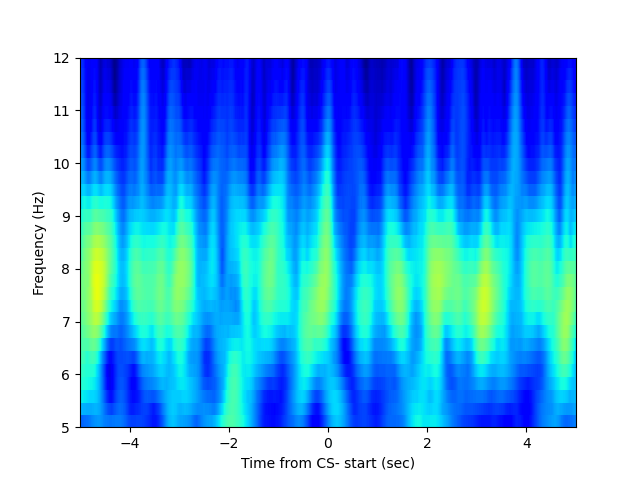

In [26]:
# Example code to plot theta at CS- starts
usv_buffer_sec = (5,5)
wv_theta_mean = wv_theta.get_pe_mean_spec(sess.csn_epochs.starts, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from CS- start (sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from CS- stop (sec)')

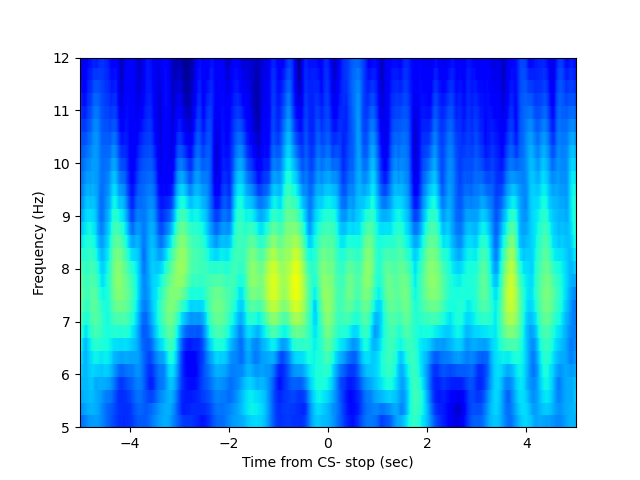

In [27]:
# Example code to plot theta at CS- stops
usv_buffer_sec = (5,5)
wv_theta_mean = wv_theta.get_pe_mean_spec(sess.csn_epochs.stops, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from CS- stop (sec)')

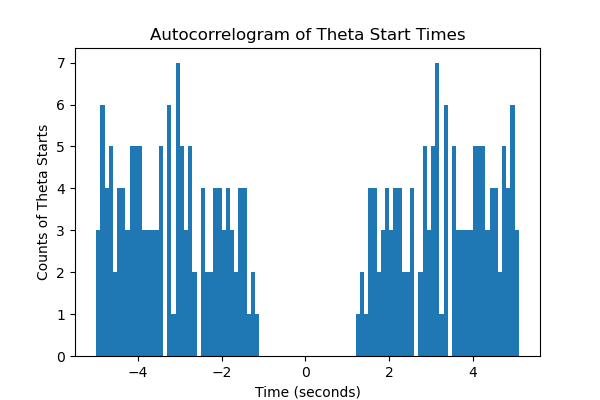

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from neuropy.utils.ccg import correlograms

theta_starts = theta_epochs.starts

theta_acg_times = theta_starts
theta_acg_ids = np.ones_like(theta_starts, dtype=int) 

sample_rate = 30  # Hz
window_size = 10  # seconds
bin_size = 0.1  # seconds
acg = correlograms(theta_acg_times, theta_acg_ids, sample_rate=sample_rate, window_size=window_size, bin_size=bin_size)

time_bins = np.linspace(-window_size / 2, window_size / 2, int(window_size / bin_size + 1))

fig, ax = plt.subplots(figsize=(6, 4))

if len(time_bins) == len(acg[0][0]) + 1:
    time_bins = time_bins[:-1]  

ax.bar(time_bins, acg[0][0], width=bin_size, align='edge')
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Counts of Theta Starts")
ax.set_title("Autocorrelogram of Theta Start Times")

plt.show()

### Read in DeepLabCut Data and sync with OpenEphys data

In [29]:
import neuropy.io.dlcio as dlcio
dlc_path = '/data3/Trace_FC/Recording_Rats/Finn2/2023_05_09_recall1'
arena_side_pix = 60  # Keep this
arena_side_cm = 25.4  # Update this after measuring!!!
pix2cm = arena_side_cm / arena_side_pix

# Read in DLC data
sess.dlc = dlcio.DLC(dlc_path, pix2cm=pix2cm)

# Smooth position, get timestamps, and get speed
sess.dlc.get_timestamps('ms_webcam', include_str="1_tone_recall")
sess.dlc.smooth_pos(bodyparts=["crown_middle", "back_middle"])
sess.dlc.timestamps["Timestamps"] = sess.dlc.timestamps["Timestamps"].dt.tz_localize("America/Detroit")
sess.dlc.get_all_speed()

ValueError: No objects to concatenate

In [ ]:
# Load in openephys times to sync
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Total seconds from start"] = (sync_df["Datetime"] - sync_df["Datetime"][0]).dt.total_seconds()

# sync DLC times to your eeg file
sess.dlc.timestamps["Total seconds from OE start"] = (sess.dlc.timestamps["Timestamps"] - sync_df["Datetime"][0]).dt.total_seconds()
sess.dlc.timestamps["eeg_time"] = np.interp(sess.dlc.timestamps["Total seconds from OE start"], sync_df["Total seconds from start"], 
                                            sync_df["eeg_time"])
sess.dlc.timestamps

In [ ]:
# Last calculate freezing times and plot again to check
frz_thresh = 0.25 # cm/sec  Adjust this to something that looks reasonable!
duration_thresh = 1 # sec, must be below the threshold above for at least that long to be considered freezing
bodypart_use = "crown_middle"
frz_bool = sess.dlc.speed[bodypart_use] < frz_thresh
frz_epochs = Epoch.from_boolean_array(frz_bool, t=sess.dlc.timestamps["eeg_time"])
frz_df = frz_epochs.to_dataframe()
frz_df = frz_df[frz_epochs.durations > duration_thresh]
frz_epochs = Epoch(frz_df)
frz_epochs

In [ ]:
%matplotlib widget
# Plot to check! Looks ok, though there might be some mismatches between theta and movement.

_, ax = plt.subplots(figsize=(12, 4))
hc, = ax.plot(sess.dlc.timestamps["eeg_time"], sess.dlc.speed["crown_middle"])
hb, = ax.plot(sess.dlc.timestamps["eeg_time"], sess.dlc.speed["back_middle"])
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5])

# Now plot theta epochs over it to triple check!
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start = sess.dlc.timestamps["eeg_time"].min(), t_stop=sess.dlc.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])

ax.legend((hc, hb, hthresh, htheta, hf), ("crown_middle", "back_middle", "freeze threshold", "theta", "frz"))

#### Double check start time

In [ ]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [ ]:
accurate_start_time = ttl_df[ttl_df['channel_states'].abs() == 1].iloc[6355]['datetimes']
accurate_start_time = accurate_start_time.tz_localize('America/Detroit')

In [ ]:
approx_start_time = sess.dlc.timestamps.loc[0, 'Timestamps']
approx_start_time

In [ ]:
adj_time_delta = (accurate_start_time - approx_start_time).total_seconds()
adj_time_delta

In [ ]:
sess.dlc.timestamps.head(1)

In [ ]:
# Try manually adjusting times in DLC data and see if it matches better!
from copy import deepcopy
dlcadj = deepcopy(sess.dlc)

dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + adj_time_delta

_, axcomb = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
ax = axcomb[0]
hc, = ax.plot(dlcadj.timestamps["eeg_time"], dlcadj.speed["crown_middle"])
hb, = ax.plot(dlcadj.timestamps["eeg_time"], dlcadj.speed["back_middle"])
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5])

# Now plot theta epochs over it to triple check!
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start = dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])

ax.legend((hc, hb, hthresh, htheta, hf), ("crown_middle", "back_middle", "freeze threshold", "theta", "frz"))
# ax.set_xlim((2535, 2565))

plot_signal_w_epochs(signal, 28, art_epochs, ax=axcomb[1])

In [ ]:
# Try manually adjusting times in DLC data and see if it matches better!
from copy import deepcopy
manually_adjust_dlc_times = -0.528  # seconds
dlcadj = deepcopy(sess.dlc)

dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))

hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):

    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5])

# Now plot theta epochs over it to triple check!
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start = dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])

ax.legend((hc, hb, hthresh, htheta, hf), ("crown_middle", "back_middle", "freeze threshold", "theta", "frz"))
# ax.set_xlim((2535, 2565))

In [ ]:
#Freezing and theta
from copy import deepcopy

manually_adjust_dlc_times = -0.528  
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 4:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs = Epoch(epochs=None, file=beta_epochs_file)
beta_epochs = beta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5], label='theta')
    
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())


In [ ]:
#Freezing and ripple
from copy import deepcopy

manually_adjust_dlc_times = -0.528  
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 4:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs = Epoch(epochs=None, file=ripple_epochs_file)
ripple_epochs = ripple_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs = Epoch(epochs=None, file=beta_epochs_file)
beta_epochs = beta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

for start, stop in zip(ripple_epochs.starts, ripple_epochs.stops):
    hripple = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5], label='ripple')
    
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())


In [ ]:
#Freezing and ripple
from copy import deepcopy
import matplotlib.pyplot as plt

# Assuming sess, frz_thresh, frz_epochs, and other necessary variables are defined elsewhere

manually_adjust_dlc_times = -0.528  
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))

# Use axhline to draw lines for visual separation (optional)
ax.axhline(0.5, color='k', linestyle='-', alpha=0.5)  # Mid-line for visual separation

# Plot freezing events below the line
for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    ax.axvspan(start, stop, ymin=0, ymax=0.5, color=[0.3, 0, 0, 0.5], label='frz')

# Plot ripple events above the line
for start, stop in zip(ripple_epochs.starts, ripple_epochs.stops):
    ax.axvspan(start, stop, ymin=0.5, ymax=1, color=[0, 0.3, 0, 0.5], label='ripple')

# Adjust the y-axis to hide the y-ticks and labels as they don't represent meaningful values in this context
ax.set_yticks([])
ax.set_ylabel("Events")

# Handle legend to avoid duplicate labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

In [ ]:
#Freezing and beta
from copy import deepcopy

manually_adjust_dlc_times = -0.528
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 4:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs = Epoch(epochs=None, file=beta_epochs_file)
beta_epochs = beta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())


    
for start, stop in zip(beta_epochs.starts, beta_epochs.stops):
    hbeta = ax.axvspan(start, stop, color=[0, 0, 0.3, 0.5], label='beta')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

In [ ]:
#Freezing and gamma  Gamma detection is wrong?
from copy import deepcopy

manually_adjust_dlc_times = -0.528 
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 4:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

gamma_epochs_file = sess.filePrefix.with_suffix(".gamma_epochs.npy")
gamma_epochs = Epoch(epochs=None, file=gamma_epochs_file)
gamma_epochs = gamma_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())


    
for start, stop in zip(gamma_epochs.starts, gamma_epochs.stops):
    hgamma = ax.axvspan(start, stop, color=[0, 0, 0.3, 0.5], label='gamma')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

In [ ]:
#Freezing and delta
from copy import deepcopy

manually_adjust_dlc_times = -0.528 
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 4:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

# theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
# theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
# theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

delta_epochs_file = sess.filePrefix.with_suffix(".delta_epochs.npy")
delta_epochs = Epoch(epochs=None, file=delta_epochs_file)
delta_epochs = delta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())


    
for start, stop in zip(delta_epochs.starts, delta_epochs.stops):
    duration = stop-start
    if duration>0.2:
        hdelta = ax.axvspan(start, stop, color=[0, 0, 0.3, 0.5], label='delta')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

In [ ]:
#Freezing and USV
from copy import deepcopy

manually_adjust_dlc_times = -0.528 
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

# theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
# theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
# theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs


# delta_epochs_file = sess.filePrefix.with_suffix(".delta_epochs.npy")
# delta_epochs = Epoch(epochs=None, file=delta_epochs_file)
# delta_epochs = delta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())


    
for start, stop in zip(usv_epochs.starts, usv_epochs.stops):
    duration = stop-start

    husv = ax.axvspan(start, stop, color=[0, 0, 0.3, 0.5], label='usv')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

## Save notebook to animal working directory

In [ ]:
from neuropy.utils.manipulate_files import save_notebook
try:
    save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")
except PermissionError:
    print('Got a weird PermissionError. Check to make sure file saved successfully')

### Load in disconnect and motion artifacts

In [ ]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

In [ ]:
%matplotlib widget

chan_plot = 28
plot_signal_w_epochs(signal, 28, art_epochs)

## Define probe group

In [ ]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Detect delta epochs

In [ ]:
#Detect Delta
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs
freq_band = (0.5, 4)
min_dur = 0.15  
max_dur = 0.5   
ignore_epochs = None  
delta_channel = 59  

if delta_channel is not None:
    signal_use = signal.time_slice(channel_id=delta_channel)
else:
    signal_use = signal
delta_epochs = detect_hpc_delta_wave_epochs(
    signal_use, freq_band=freq_band, min_dur=min_dur, max_dur=max_dur, ignore_epochs=ignore_epochs
)

## Detect Beta epochs

In [ ]:
#Detect Beta
from neuropy.analyses.oscillations import detect_beta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
beta_channel = 59
  
if beta_channel is None:
    beta_epochs, beta_power = detect_beta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=beta_channel)
    beta_epochs, beta_power = detect_beta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

## Detect Theta epochs

In [ ]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 59

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

## Detect SWR Epochs

In [ ]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 59
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


## Detect gamma epochs

In [ ]:
125/1250

In [ ]:
# Detect Gamma
from neuropy.analyses.oscillations import detect_gamma_epochs
from neuropy.analyses.oscillations import Gamma
band=(40, 80)
lowthresh = 1.5  
highthresh = 3 
minDistance = 300
minDuration = 125
gamma_channel = 59

# Use this if you don't know the specific channel for gamma detection
if gamma_channel is None:
    signal_use = signal.time_slice(channel_id=gamma_channel)
else:
    # If a specific channel for gamma is known
    signal_use = signal

gammadetect = Gamma()
# gammadetect.get_peak_intervals(signal.traces, lowthresh=lowthresh, highthresh=highthresh, minDistance=minDistance, minDuration=minDuration)
peakevents, gamma_amp = Gamma().get_peak_intervals(signal_use.traces[gamma_channel, :], band=band, lowthresh=lowthresh, highthresh=highthresh, 
                                        minDistance=minDistance, minDuration=minDuration, return_amplitude=True)
# csd=csd(self, period, refchan, band=band, window=1250)
gamma_epochs = Epoch(pd.DataFrame({"start" : peakevents[:, 0]/sess.eegfile.sampling_rate, "stop": peakevents[:, 1]/sess.eegfile.sampling_rate,
                   "label": ""}))
# pd.DataFrame(dict(start=peakevents[:, 0]/sess.eegfile.sampling_rate, stop=peakevents[:, 1]/sess.eegfile.sampling_rate))

In [ ]:
gamma_epochs

In [ ]:
np.arange(0, len(gamma_amp))/sess.eegfile.sampling_rate 

In [ ]:
import scipy.stats as stats
_, ax = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
plot_signal_w_epochs(signal, gamma_channel, gamma_epochs, ax=ax[0])
ax[1].plot(np.arange(0, len(gamma_amp))/sess.eegfile.sampling_rate , stats.zscore(gamma_amp))

## Sync via CS+ or CS- times in tone_recall or control_tone_recall or tone_habituation session

In [ ]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [ ]:
import tracefc.io.traceio as traceio

if "training" in str(sess.basepath):
    # For tone habituation
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))
    
    # For CS+ during training
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
elif "recall" in str(sess.basepath):
    # For tone recall CS+
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
    
    # For control tone recall CS-
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))

In [ ]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

In [ ]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = pd.Timedelta(0.8, unit="seconds")
cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
cs_oe_stop_df = traceio.trace_ttl_to_openephys(cs_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
# Convert to times in combined eeg file
cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)
cs_stops_combined = oeio.recording_events_to_combined_time(cs_oe_stop_df, sync_df)

csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)
csn_oe_stop_df = traceio.trace_ttl_to_openephys(csn_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)
csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)

In [ ]:
cs_starts

In [ ]:
cs_oe_start_df

### How to write CS+ to neuroscope event file

In [ ]:
cs_tone_recall_epochs = Epoch({"start": cs_starts_combined, "stop": cs_stops_combined, "label": ["CS+"]*len(cs_starts_combined)})
cs_tone_recall_epochs
sess.recinfo.write_epochs(cs_tone_recall_epochs, "cs+")

In [ ]:
cs_tone_recall_epochs

In [ ]:
sess_use

In [ ]:
from tracefc.io.traceio import grab_usv_folder
csp_wav = grab_usv_folder(sess.basepath, 'csp')
print(csp_wav)
# Get CS+ times and plot to check
cs_wav_epochs = detect_tone(csp_wav, freq_lims=(6900, 7100), thresh=0.05, tone_length=10, tone_label="CS+", plot_check=True)
# Check that lags are consistent
if (animal == 'Django') & (sess_name == 'training'):
    cs_starts_combined = cs_starts_combined[:5]
    cs_stops_combined = cs_stops_combined[:5]
cs_start_lags = cs_starts_combined - cs_wav_epochs.starts
print(f"Mean start lag time of {np.mean(cs_start_lags):0.3F} sec with std = {np.std(cs_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
cs_stop_lags = cs_stops_combined - cs_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(cs_stop_lags):0.3F} sec with std = {np.std(cs_stop_lags):0.3F} sec.")

Ditto for CS-

In [ ]:
# Detect CS- in audio recording.
csn_wav = grab_usv_folder(sess.basepath, "csn")
print(csn_wav)

# Get CS+ times and plot to check
csn_wav_epochs, csn_wav_stop = detect_tone(csn_wav, freq_lims=(900, 1100), thresh=-0.1, tone_length=10, tone_label="CS-", 
                                           plot_check=True, return_stop=True)

# Check that lags are consistent
csn_start_lags = csn_starts_combined - csn_wav_epochs.starts
print(f"Mean start lag time of {np.mean(csn_start_lags):0.3F} sec with std = {np.std(csn_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
csn_stop_lags = csn_stops_combined - csn_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(csn_stop_lags):0.3F} sec with std = {np.std(csn_stop_lags):0.3F} sec.")

Now try to sync to start tone 

In [ ]:
ctx_recall_wav = sorted((sess.basepath / "3_post").glob("**/*.wav"))[0]
print(ctx_recall_wav)

# Get CS+ times and plot to check
start_wav_epochs = detect_tone(ctx_recall_wav, freq_lims=(450, 550), thresh=10, tone_length=0.5, tone_label="start_tone", plot_check=True)

## Sync recorded USV times to ephys file

In [ ]:
# Read in USV times from tone recall session
from neuropy.io.usvio import DeepSqueakIO
csp_wav = Path(csp_wav)
usv_detect_file = sorted(csp_wav.parent.glob(f"**/{csp_wav.name[:-4]}*_cell.mat"))[0]

ds_calls = DeepSqueakIO(filename=usv_detect_file)
ds_calls.load_calls()
ds_calls.usv_df

Plot lags vs time to check for drift between ephys and audio recordings and correct if necessary

In [ ]:
from scipy.linalg import lstsq

_, ax = plt.subplots(layout='tight')
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)
hl = ax.plot(cs_times_wav, cs_lags_comb)
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = cs_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(cs_lags_comb.reshape(-1)), cs_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
hfit = ax.plot(cs_times_wav.T.reshape(-1), p[0] + p[1]*cs_times_wav.T.reshape(-1), 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [ ]:
# Sanity check code to output corrected CS times from WAV file to Neuroscope
cs_wav_starts_aligned = cs_wav_epochs.starts + p[0] + p[1]*cs_wav_epochs.starts
cs_wav_stops_aligned = cs_wav_epochs.stops + p[0] + p[1]*cs_wav_epochs.stops
cs_wav_epochs_aligned = Epoch({"start": cs_wav_starts_aligned, "stop": cs_wav_stops_aligned, 
                               "label": ["CS+ from WAV file"]*len(cs_wav_stops_aligned)})


cs_epochs_files = sess.filePrefix.with_suffix(".cs_wav_epochs.npy")
cs_wav_epochs_aligned.save(cs_epochs_files)
sess.recinfo.write_epochs(cs_wav_epochs_aligned, ext="wv+")

In [ ]:
cs_wav_epochs_aligned

Now correct that drift and find corrected lags!

In [ ]:
# This should eventually be folded into the DeepSqueakIO class!
# Bowen question: 
calls_accept_df = ds_calls.usv_df[ds_calls.usv_df['Accept'] == 1]
call_starts_wav = calls_accept_df['Begin_Time'].values
call_stops_wav = call_starts_wav + calls_accept_df['Duration'].values
calls_accept_df.insert(0, "start", call_starts_wav + p[0] + p[1]*call_starts_wav)
calls_accept_df.insert(1, "stop", call_stops_wav + p[0] + p[1]*call_stops_wav)
calls_accept_df.insert(calls_accept_df.shape[1], "label", "")
good_calls = Epoch(calls_accept_df)

# output to neuroscope and neuropy
sess.recinfo.write_epochs(good_calls, ext="usv")
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
good_calls.save(usv_epochs_file)

In [ ]:
good_calls

## Save notebook to working directory

In [ ]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)